In [1]:
import os
import pickle
import torch
import numpy as np
import scipy.sparse as sp
import dgl
from tqdm.auto import tqdm
import math
import random

from utils import select_source, compute_rank_error, compute_hit_ratio

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\Users\larry\OneDrive - 國立成功大學 National Cheng Kung University\大四\大四下\資料探勘\SNA-make-friend\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
EPOCHS = 100
TEST_RATIO = 0.3  # ratio for splitting the test set
DEVICE = "cpu"

In [3]:
with open(os.path.join("facebook", "combined-adj-sparsefeat.pkl"), "rb") as f:
    friendship_matrix, feature_matrix = pickle.load(f, encoding='latin1')

print(f"Friendship matrix shape : {friendship_matrix.shape}")
print(f"Feature matrix shape    : {feature_matrix.shape}")

src, dst = np.nonzero(friendship_matrix)
g = dgl.graph((src, dst))
g.ndata['feat'] = torch.tensor(feature_matrix.todense(), dtype=torch.float32)
g

Friendship matrix shape : (4039, 4039)
Feature matrix shape    : (4039, 1283)


Graph(num_nodes=4039, num_edges=176468,
      ndata_schemes={'feat': Scheme(shape=(1283,), dtype=torch.float32)}
      edata_schemes={})

In [4]:
def split_dataset(g):

    u, v = g.edges()

    eids = np.arange(g.number_of_edges())
    np.random.seed( SEED )
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set

    # get positive edges for test and train
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    # split the negative edges for training and testing
    np.random.seed( SEED )
    neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

    # construct positive and negative graphs for training and testing
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

    # training graph
    train_g = dgl.remove_edges(g, eids[:test_size])
    train_g = dgl.add_self_loop(train_g)

    return {
        "train_pos_g": train_pos_g,
        "train_neg_g": train_neg_g,
        "test_pos_g":  test_pos_g,
        "test_neg_g":  test_neg_g,
        "train_g":     train_g
    }

In [5]:
from model import Pipeline

pipeline = Pipeline("GCN", 16, feature_matrix.shape[1])
ds = split_dataset(g)
train_losses = pipeline.train(ds)

100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


AUC: 0.960658


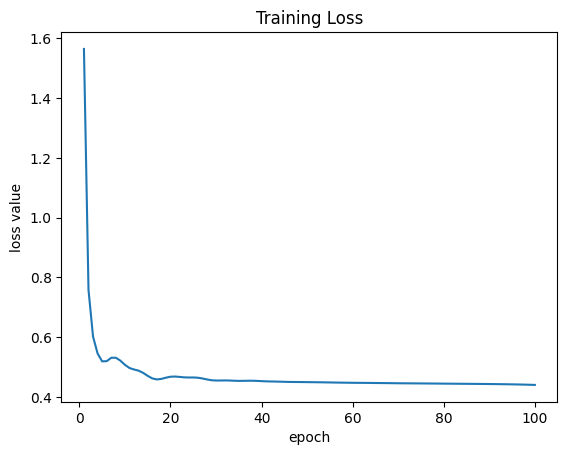

In [6]:
import matplotlib.pyplot as plt

plt.title("Training Loss")
plt.plot(range(1, EPOCHS+1), train_losses)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

In [7]:
recommend_list = pipeline.recommend(g, 0)
print(recommend_list[:3])

[(1564, 3.088592529296875), (1699, 1.4458916187286377), (1965, 1.41013503074646)]


In [8]:
MAX_CHANGES = 10
NUM_PAIRS = 5

RESTART_RATIO = 0.1
EPSILON = 1e-5
WALK_GRAPH = "weighted"

START_TEMP = 10000
END_TEMP = 0
COOLING_RATE = 0.93
MAX_ITER = 100

In [9]:
import random

pairs = []
start = 100
end = 200

random.seed(SEED)
targets = random.sample(range(0, friendship_matrix.shape[0]-1), NUM_PAIRS)

for tgt in targets:
    recommend_list = pipeline.recommend(g, tgt)
    src = select_source(recommend_list, start, end)
    pairs.append((src, tgt))

pairs[:5]

[(2484, 2619), (1018, 456), (74, 102), (3069, 3037), (1077, 1126)]

In [10]:
def random_walk_with_restart(graph, start_point, restart_ratio, max_iter=100, tol=1e-6, device=torch.device("cpu")):
    # graph is already torch tensor
    init_vector = torch.zeros((graph.shape[0], 1), device=device)
    init_vector[start_point, 0] = 1
    p = init_vector.clone()
    
    for _ in range(max_iter):
        prev_p = p.clone()
        p = (1 - restart_ratio) * torch.mm(graph, p) + restart_ratio * init_vector
        if torch.norm(p - prev_p, p=1).item() < tol:
            break
    return p

def construct_normalized_graph(friends, features, epsilon=1e-4, walk_graph="weighted", device=torch.device("cpu")):
    if walk_graph == "adj":
        # normalize friends
        friends += epsilon * torch.eye(friends.shape[0], device=device)
        normalized_friends = friends / friends.sum(dim=1, keepdim=True)

    elif walk_graph == "weighted":
        # Compute feature inner product matrix
        feature_inner_product = torch.mm(features, features.t())
        
        # Replace the original adjacency matrix values with feature inner product values
        neighbors = (friends == 1)
        friends = friends.clone()  # Make a copy to avoid modifying the original tensor
        friends[neighbors] = feature_inner_product[neighbors]
        
        # Normalize the friends matrix
        friends += epsilon * torch.eye(friends.shape[0], device=device)
        normalized_friends = friends / friends.sum(dim=1, keepdim=True)

    else:
        raise ValueError("Error in reading parameter walk graph!!")

    return normalized_friends

In [11]:
def init_answer(node_size, feature_size):

    feature_change_size = np.random.choice(MAX_CHANGES, 1)[0]
    node_change_size = MAX_CHANGES - feature_change_size
    feature_list = np.arange(feature_size)
    node_list = np.arange(feature_size, feature_size + node_size)
    np.random.shuffle(feature_list)
    np.random.shuffle(node_list)

    return list(feature_list[:feature_change_size]) + list(node_list[:node_change_size])

def alter_graph(input_graph, answer, src):
    input_graph = input_graph.clone()
    feature_size = input_graph.ndata['feat'].shape[1]

    for a in answer:
        if a < feature_size:
            replaced_value = 1 - input_graph.ndata['feat'][src, a]
            input_graph.ndata['feat'][src, a] = 0 if replaced_value < 0 else replaced_value
        else:
            a -= feature_size
            if not input_graph.has_edges_between([src], [a])[0]:
                input_graph.add_edges([src], [a])
                input_graph.add_edges([a], [src])
            else:
                eid = input_graph.edge_ids(src, a)
                input_graph.remove_edges(eid)

    return input_graph

In [12]:
def simulated_annealing(
    g, pair
):
    temperature = START_TEMP

    user_id, tgt = pair
    g_copy = dgl.remove_self_loop(g.clone())
    device = torch.device(DEVICE)

    # 隨機挑選初始值並產生初始解
    node_size = g.ndata['feat'].shape[0]
    feature_size = g.ndata['feat'].shape[1]
    curr_answer = init_answer(node_size, feature_size)
    alter_g = alter_graph(g_copy, curr_answer, user_id)

    # get friends and feature metrix
    alter_g = dgl.remove_self_loop(alter_g)
    # get friends and feature metrix
    friends = alter_g.adj().to_dense()
    features = alter_g.ndata['feat'].to(device)
    # turn to float
    friends = friends.type(torch.FloatTensor).to(device)

    normalized_friends = construct_normalized_graph(friends, features, EPSILON, WALK_GRAPH, device)
    proximity = random_walk_with_restart(normalized_friends, tgt, RESTART_RATIO, device=device)
    
    proximity = proximity.reshape(-1)
    curr_fitness = proximity[user_id]

    for _ in tqdm(range(MAX_ITER)):
        if temperature == END_TEMP:
            return curr_answer, curr_fitness
    
        # generate next answer -> random pick & alter it
        alter_pos = np.random.choice(len(curr_answer), 1)[0]
        r = np.random.randint(0, node_size+feature_size)

        while r in curr_answer:
            r = np.random.randint(0, node_size+feature_size)

        next_answer = curr_answer[:]
        next_answer[alter_pos] = r
        alter_g = alter_graph(g_copy, next_answer, user_id)

        # get friends and feature metrix
        alter_g = dgl.remove_self_loop(alter_g)
        # get friends and feature metrix
        friends = alter_g.adj().to_dense()
        features = alter_g.ndata['feat'].to(device)
        # turn to float
        friends = friends.type(torch.FloatTensor).to(device)

        normalized_friends = construct_normalized_graph(friends, features, EPSILON, WALK_GRAPH, device)
        proximity = random_walk_with_restart(normalized_friends, tgt, RESTART_RATIO, device=device)

        proximity = proximity.reshape(-1)

        next_fitness = proximity[user_id]
        improved_fitness = next_fitness - curr_fitness

        if improved_fitness > 0:
            curr_fitness = next_fitness
            curr_answer = next_answer
        else:
            try: # 避免指數計算 overflow
                prob = math.exp(-improved_fitness/temperature)
            except OverflowError:
                prob = 0 # 值過小設為零

            if random.random() < prob:
                # 允許錯誤=>更新
                curr_fitness = next_fitness
                curr_answer = next_answer

        temperature *= COOLING_RATE

    return alter_graph(g_copy, curr_answer, src)

In [13]:
origin_ranks, new_ranks = [], []

for pair in pairs:
    g_change = simulated_annealing(g, pair)

    origin_rank = pipeline.predict_rank(g, pair[0], pair[1])

    ds = split_dataset(g_change)
    

    #new_rank = pipeline.predict_rank(g_change, pair[0], pair[1])

    new_pipeline = Pipeline("GCN", 16, feature_matrix.shape[1])
    train_losses = new_pipeline.train(ds)
    new_rank = new_pipeline.predict_rank(g_change, pair[0], pair[1])

    origin_ranks.append(origin_rank)
    new_ranks.append(new_rank)

print( compute_rank_error(origin_ranks, new_ranks) )    

100%|██████████| 100/100 [00:14<00:00,  7.14it/s]



AUC: 0.967826


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]



AUC: 0.967718


100%|██████████| 100/100 [00:13<00:00,  7.39it/s]



AUC: 0.967857


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]



AUC: 0.965950


100%|██████████| 100/100 [00:14<00:00,  7.02it/s]



AUC: 0.953676
{'average': -74.6, 'max': 10, 'min': -260}


In [14]:
print(origin_ranks)
print(new_ranks)

[181, 181, 181, 181, 181]
[203, 441, 171, 230, 233]
